# Classification of Body Performance
Team 5

| Name | Email | Contribution |
| --- | --- | --- |
| Anni Wang | anniwang1998@berkeley.edu |  |
| Tianhao Wu | thwu@berkeley.edu |  |
| Yueting Wu | yueting_wu@berkeley.edu |  |
| Zhiyong Jiang | joe_jiangzhiyong@berkeley.edu |  |
| Zihe Yan | sxakyzh0805@berkeley.edu |  |

In [ ]:
import numpy as np
import pandas as pd
# !pip install -U seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.multiclass import OneVsRestClassifier

import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import cycle
!pip install bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# from google.colab import files
import io

# 1. Data

## 1.1 Data Import and Integration

In [ ]:
# Run this cell if the file has not been uploaded, otherwise skip this cell
# uploaded = files.upload()
# df = pd.read_csv(io.StringIO(uploaded['bodyPerformance.csv'].decode('utf-8')))
url= 'https://raw.githubusercontent.com/6shun/IEOR242_Project_BodyHealth/main/bodyPerformance.csv'
#df = pd.read_csv('bodyPerformance.csv')
df = pd.read_csv(url)
df

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C
13389,21.0,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D
13390,39.0,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A
13391,64.0,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D


## 1.2 Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [ ]:
df['class'] = df['class'].map({"A":"Good", "B":"Ordinary", "C":"Ordinary", "D":"Bad"})

# 2. Exploratory Data Analysis

## 2.1 Visualization

In [ ]:
# # Examine covariance
# sns.pairplot(df, hue='class');

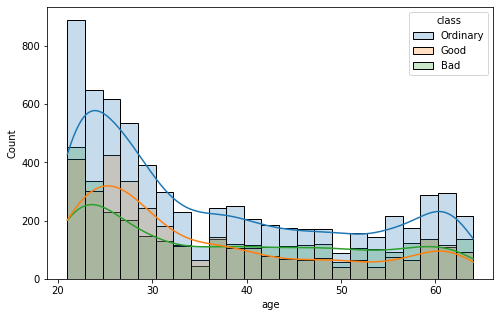

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='age', hue='class', kde=True, alpha=0.25);

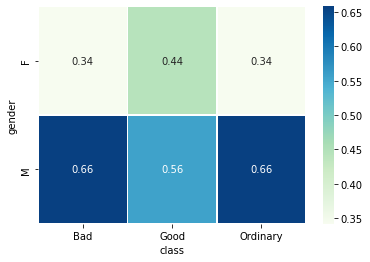

In [ ]:
tmp = pd.pivot_table(df, index='gender', columns='class', aggfunc='size')
# Normalize by F and M
tmp = tmp / tmp.sum()
sns.heatmap(tmp, cmap="GnBu", annot=True, linewidths=.5);

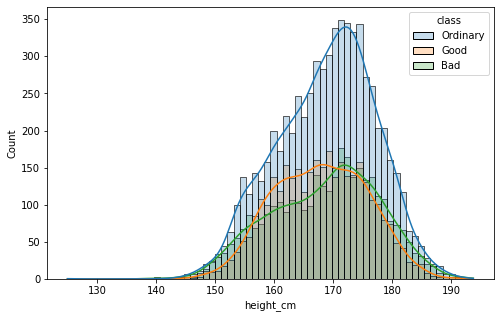

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='height_cm', hue='class', kde=True, alpha=0.25);

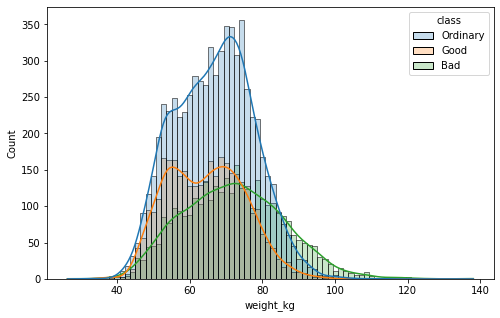

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='weight_kg', hue='class', kde=True, alpha=0.25);

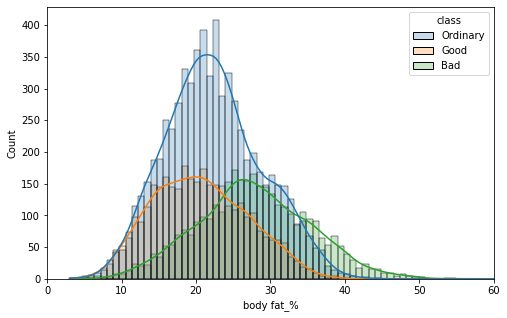

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='body fat_%', hue='class', kde=True, alpha=0.25);
plt.xlim(left=0, right=60);

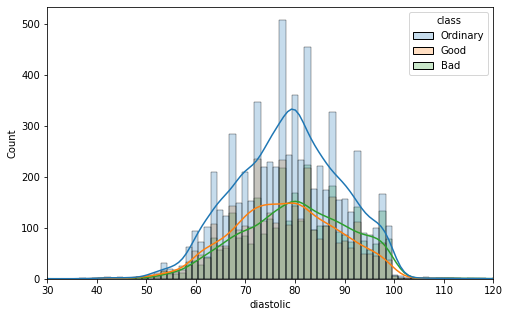

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='diastolic', hue='class', kde=True, alpha=0.25);
plt.xlim(left=30, right=120);

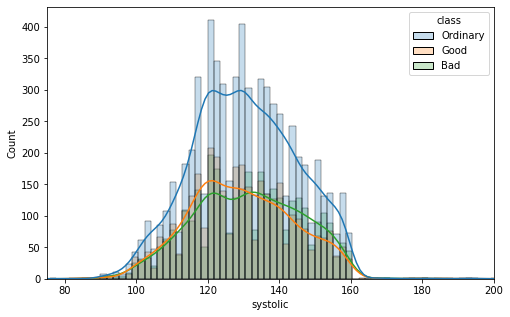

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='systolic', hue='class', kde=True, alpha=0.25);
plt.xlim(left=75, right=200);

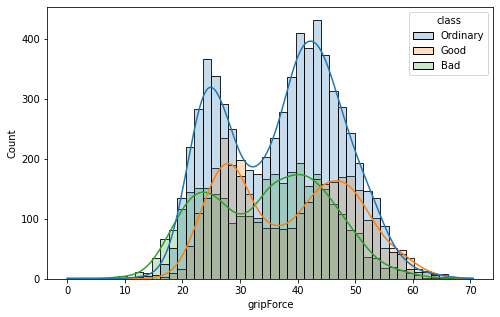

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='gripForce', hue='class', kde=True, alpha=0.25);

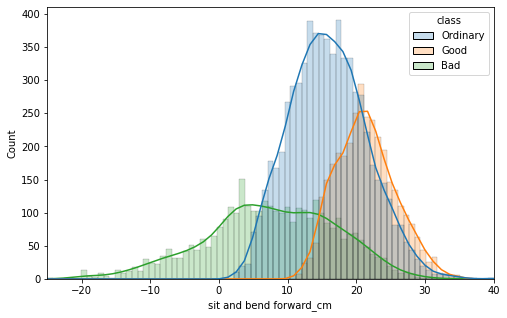

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='sit and bend forward_cm', hue='class', kde=True, alpha=0.25);
plt.xlim(left=-25, right=40);

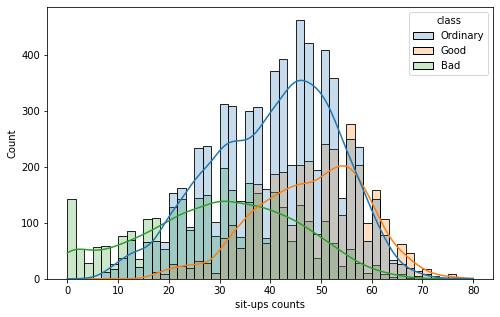

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='sit-ups counts', hue='class', kde=True, alpha=0.25);

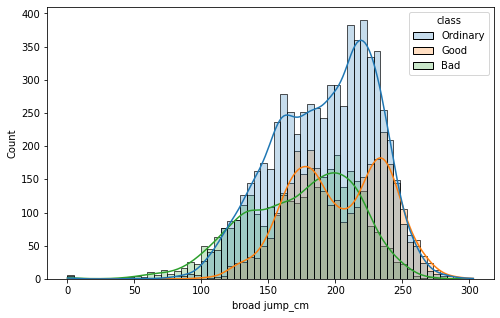

In [ ]:
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='broad jump_cm', hue='class', kde=True, alpha=0.25);

## 2.2 Feature Engineering

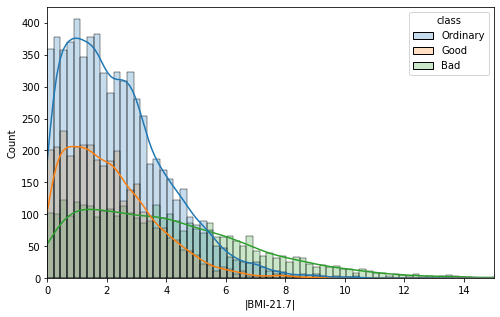

In [ ]:
# BMI
df['BMI'] = df['weight_kg'] / (df['height_cm']/100)**2
df['|BMI-21.7|'] = abs(df['BMI'] - 21.7)
plt.figure(figsize=(8, 5));
sns.histplot(data=df, x='|BMI-21.7|', hue='class', kde=True, alpha=0.25);
plt.xlim(left=0, right=15);

# 3. Modeling

In [ ]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == "M" else 0)

df = df.rename({"body fat_%":"body_fat_percent", 
           "sit and bend forward_cm":"sit_and_bend_forward_cm",
           "sit-ups counts":"sit_ups_counts",
           "broad jump_cm":"broad_jump_cm",
           "|BMI-21.7|":"abs_BMI_minus_21dot7"}, axis=1)

features = ['gender', 'height_cm', 'weight_kg', 'body_fat_percent', 'diastolic',
            'systolic', 'gripForce', 'sit_and_bend_forward_cm', 'sit_ups_counts',
            'broad_jump_cm', 'abs_BMI_minus_21dot7']
X = df[features]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=242)

In [ ]:
def generate_performance(y_pred=None):
    # accuracy, precision, recall, F-Score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    F_Score = f1_score(y_test, y_pred, average='weighted') 
    res = [accuracy_score(y_test, y_pred), precision, recall, F_Score]
    return [round(num, 4) if num else None for num in res]

## 3.1 Baseline Model

In [ ]:
# y_pred_train_baseline = [y_train.value_counts().index[0]] * len(y_train)
y_pred_test_baseline = [y_train.value_counts().index[0]] * len(y_test)

# print("Train Score:", round(accuracy_score(y_train, y_pred_train_baseline), 4))
print("Test Score:", round(accuracy_score(y_test, y_pred_test_baseline), 4))

baseline_compare = generate_performance(y_pred_test_baseline)
baseline_compare

Test Score: 0.4945


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4945, 0.2445, 0.4945, 0.3272]

## 3.2 Logistic Regression

In [ ]:
# Question: unable to train?
tmp = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
# display(tmp)
tmp['class'] = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)['class'].apply(lambda x: 1 if x == "Good" else 0)
mod = smf.logit(formula = "class ~ gender + height_cm + weight_kg + body_fat_percent + diastolic + systolic + gripForce + sit_and_bend_forward_cm + sit_ups_counts + broad_jump_cm + abs_BMI_minus_21dot7", 
                data=tmp)
res = mod.fit()
print(res.summary())

SyntaxError: ignored

In [ ]:
grid_values = {'C': np.geomspace(start=1, stop=200, num=11) / 100} 
clf = LogisticRegression(random_state=242, solver='liblinear')
clf_cv = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
clf_cv.fit(X_train, y_train);

Best accuarcy: 0.713759248719408
Best C: 2.0000000000000004


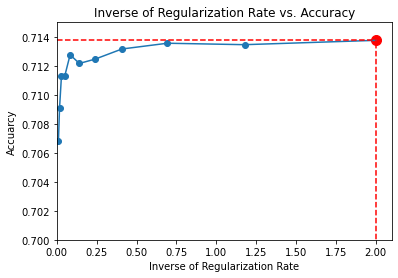

In [ ]:
accuarcy = clf_cv.cv_results_['mean_test_score'] 
C = clf_cv.cv_results_['param_C'].data #
best_parameter = clf_cv.best_params_['C'] #

# plt.figure(figsize=(8,5));
plt.plot(C, accuarcy);
plt.scatter(C, accuarcy);
plt.ylim(bottom=0.7, top=0.715); #
plt.xlim(left=0); #
plt.xlabel("Inverse of Regularization Rate");
plt.ylabel("Accuarcy");
plt.scatter(best_parameter, max(accuarcy), c='r',s=100);
plt.plot(np.linspace(0.0, best_parameter, 101), [max(accuarcy) for i in range(101)], c='r', linestyle='dashed');
plt.plot([best_parameter for i in range(101)], np.linspace(0.0, max(accuarcy), 101),  c='r', linestyle='dashed');
plt.title("Inverse of Regularization Rate vs. Accuracy"); # 
print("Best accuarcy:", max(accuarcy))
print("Best C:", best_parameter) #

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


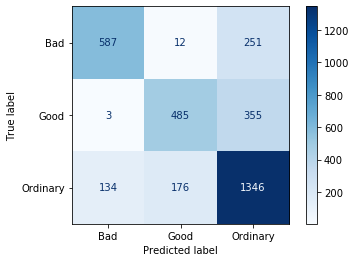

In [ ]:
log = LogisticRegression(random_state=242, solver='liblinear', C=best_parameter)
y_pred_test_logistic = log.fit(X_train, y_train).predict(X_test) #
y_pred = y_pred_test_logistic

disp = plot_confusion_matrix(log, X_test, y_test, display_labels=["Bad", "Good", "Ordinary"], cmap=plt.cm.Blues)
plt.show()

In [ ]:
logistic_compare = generate_performance(y_pred_test_logistic)
logistic_compare

[0.722, 0.7281, 0.722, 0.7193]

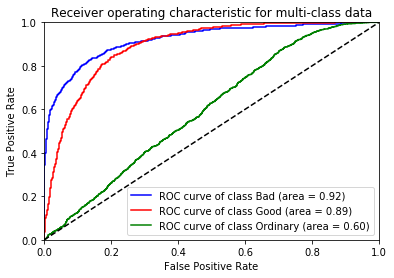

In [ ]:
X = df[features]
y = df['class']

y = label_binarize(y, classes=["Bad", "Good", "Ordinary"])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=242)

classifier = OneVsRestClassifier(LogisticRegression(random_state=242, solver='liblinear'))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(["Bad", "Good", "Ordinary"][i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

X = df[features]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=242)

## 3.3 Random Forest

In [ ]:
grid_values = {'ccp_alpha': np.geomspace(start=1, stop=10000, num=11) / 10000} 
clf = RandomForestClassifier(random_state=242)
clf_cv = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
clf_cv.fit(X_train, y_train);

Best accuarcy: 0.7684189573215351
Best ccp_alpha: 0.0001


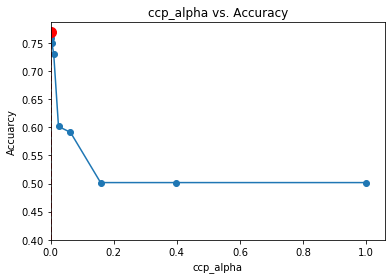

In [ ]:
accuarcy = clf_cv.cv_results_['mean_test_score'] 
ccp = clf_cv.cv_results_['param_ccp_alpha'].data #
best_parameter = clf_cv.best_params_['ccp_alpha'] #

# plt.figure(figsize=(8,5));
plt.plot(ccp, accuarcy);
plt.scatter(ccp, accuarcy);
plt.ylim(bottom=0.4); #
plt.xlim(left=0); #
plt.xlabel("ccp_alpha"); #
plt.ylabel("Accuarcy");
plt.scatter(best_parameter, max(accuarcy), c='r',s=100);
plt.plot(np.linspace(0.0, best_parameter, 101), [max(accuarcy) for i in range(101)], c='r', linestyle='dashed');
plt.plot([best_parameter for i in range(101)], np.linspace(0.0, max(accuarcy), 101),  c='r', linestyle='dashed');
plt.title("ccp_alpha vs. Accuracy"); # 
print("Best accuarcy:", max(accuarcy))
print("Best ccp_alpha:", best_parameter) #

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


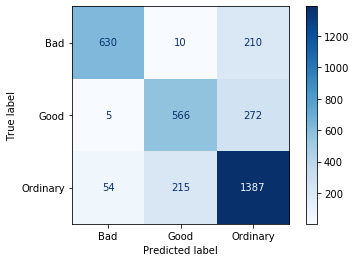

In [ ]:
rf = RandomForestClassifier(random_state=242, ccp_alpha=best_parameter)
y_pred_test_rf = rf.fit(X_train, y_train).predict(X_test) #
y_pred = y_pred_test_rf

disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=["Bad", "Good", "Ordinary"], cmap=plt.cm.Blues)
plt.show()

In [ ]:
rf_compare = generate_performance(y_pred_test_rf)
rf_compare

[0.7713, 0.7791, 0.7713, 0.7713]

## 3.4 Bagging

In [ ]:
grid_values = {'max_features': range(1, len(X_train.columns) + 1)} 
clf = RandomForestClassifier(random_state=242)
clf_cv = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
clf_cv.fit(X_train, y_train);

Best accuarcy: 0.7679206023095274
Best max_features: 2


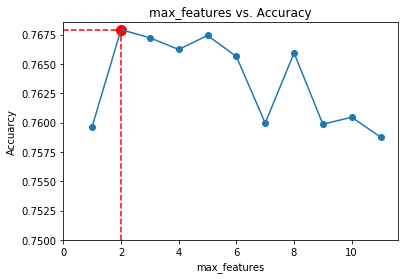

In [ ]:
accuarcy = clf_cv.cv_results_['mean_test_score'] 
max_features = clf_cv.cv_results_['param_max_features'].data #
best_parameter = clf_cv.best_params_['max_features'] #

# plt.figure(figsize=(8, 5));
plt.plot(max_features, accuarcy);
plt.scatter(max_features, accuarcy);
plt.ylim(bottom=0.75); #
plt.xlim(left=0); #
plt.xlabel("max_features"); #
plt.ylabel("Accuarcy");
plt.scatter(best_parameter, max(accuarcy), c='r',s=100);
plt.plot(np.linspace(0.0, best_parameter, 101), [max(accuarcy) for i in range(101)], c='r', linestyle='dashed');
plt.plot([best_parameter for i in range(101)], np.linspace(0.0, max(accuarcy), 101),  c='r', linestyle='dashed');
plt.title("max_features vs. Accuracy"); # 
print("Best accuarcy:", max(accuarcy))
print("Best max_features:", best_parameter) #

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


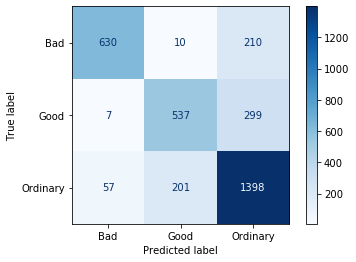

In [ ]:
bag = RandomForestClassifier(random_state=242, max_features=best_parameter)
y_pred_test_bag = bag.fit(X_train, y_train).predict(X_test) #
y_pred = y_pred_test_bag

disp = plot_confusion_matrix(bag, X_test, y_test, display_labels=["Bad", "Good", "Ordinary"], cmap=plt.cm.Blues)
plt.show()

In [ ]:
bag_compare = generate_performance(y_pred_test_bag)
bag_compare

[0.7659, 0.7736, 0.7659, 0.7651]

## 3.5 Gradient Boosting

In [ ]:
grid_values = {'ccp_alpha': np.geomspace(start=1, stop=10000, num=11) / 10000} 
clf = GradientBoostingClassifier(random_state=242)
clf_cv = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
clf_cv.fit(X_train, y_train);

Best accuarcy: 0.760552711999191
Best ccp_alpha: 0.0001


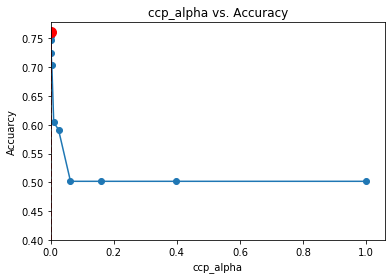

In [ ]:
accuarcy = clf_cv.cv_results_['mean_test_score'] 
ccp = clf_cv.cv_results_['param_ccp_alpha'].data #
best_parameter = clf_cv.best_params_['ccp_alpha'] #

# plt.figure(figsize=(8,5));
plt.plot(ccp, accuarcy);
plt.scatter(ccp, accuarcy);
plt.ylim(bottom=0.4); #
plt.xlim(left=0); #
plt.xlabel("ccp_alpha"); #
plt.ylabel("Accuarcy");
plt.scatter(best_parameter, max(accuarcy), c='r',s=100);
plt.plot(np.linspace(0.0, best_parameter, 101), [max(accuarcy) for i in range(101)], c='r', linestyle='dashed');
plt.plot([best_parameter for i in range(101)], np.linspace(0.0, max(accuarcy), 101),  c='r', linestyle='dashed');
plt.title("ccp_alpha vs. Accuracy"); # 
print("Best accuarcy:", max(accuarcy))
print("Best ccp_alpha:", best_parameter) #

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


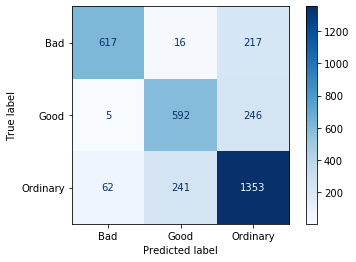

In [ ]:
gb = GradientBoostingClassifier(random_state=242, ccp_alpha=best_parameter)
y_pred_test_gb = gb.fit(X_train, y_train).predict(X_test) #
y_pred = y_pred_test_gb

disp = plot_confusion_matrix(gb, X_test, y_test, display_labels=["Bad", "Good", "Ordinary"], cmap=plt.cm.Blues)
plt.show()

In [ ]:
gb_compare = generate_performance(y_pred_test_gb)
gb_compare

[0.765, 0.7729, 0.765, 0.7657]

## 3.6 Neural Network

In [ ]:
grid_values = {'hidden_layer_sizes': [(8,), (9,), (10, 5),(9, 4), (9, 5), (9, 6), (12, 7, 5), (10, 8, 4)]}
clf = MLPClassifier(random_state=242, max_iter=1000)
clf_cv = GridSearchCV(clf, param_grid=grid_values, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
clf_cv.fit(X_train, y_train);

Best accuarcy: 0.7290915481924962
Best hidden_layer_sizes: (9, 6)


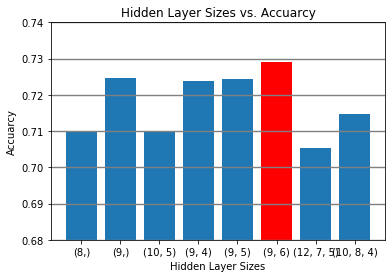

In [ ]:
accuarcy = clf_cv.cv_results_['mean_test_score'] 
hidden_layer_sizes = clf_cv.cv_results_['param_hidden_layer_sizes'].data #
best_parameter = clf_cv.best_params_['hidden_layer_sizes'] #

# plt.figure(figsize=(8,5));
plt.grid(True, axis='y', color = "grey", linewidth = "1.4")
x_pos = [i for i, _ in enumerate(hidden_layer_sizes)]
plt.bar(x=x_pos, height=accuarcy);
accuarcy = [num if num == max(accuarcy) else 0 for num in accuarcy]
plt.bar(x=x_pos, height=accuarcy, color='r');

plt.xticks(x_pos, hidden_layer_sizes)
plt.ylim(bottom=0.68, top=0.74); #
plt.xlabel("Hidden Layer Sizes"); #
plt.ylabel("Accuarcy");
plt.title("Hidden Layer Sizes vs. Accuarcy"); # 
print("Best accuarcy:", max(accuarcy))
print("Best hidden_layer_sizes:", best_parameter) #

C:\Users\Joe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


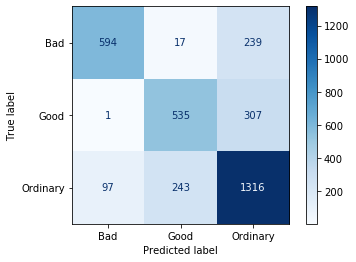

In [ ]:
nn = MLPClassifier(random_state=242, max_iter=1000, hidden_layer_sizes=best_parameter)
y_pred_test_nn = nn.fit(X_train, y_train).predict(X_test) #
y_pred = y_pred_test_nn

disp = plot_confusion_matrix(nn, X_test, y_test, display_labels=["Bad", "Good", "Ordinary"], cmap=plt.cm.Blues)
plt.show()

In [ ]:
nn_compare = generate_performance(y_pred_test_nn)
nn_compare

[0.7301, 0.7367, 0.7301, 0.7299]

# 4. Model Evaluation and Comparison

## 4.1 Model Comparison

In [ ]:
comparison = pd.DataFrame(data=[baseline_compare, logistic_compare, rf_compare,
                                bag_compare, gb_compare, nn_compare], 
             index=['Baseline Model', 'Logistic Regression', 'Random Forest', 
                    'Bagging', 'Gradient Boosting', 'Neural Network'],
             columns=['Accuracy', 'Precision', 'Recall', 'F-Score'])
comparison

,Accuracy,Precision,Recall,F-Score
Baseline Model,0.4945,0.2445,0.4945,0.3272
Logistic Regression,0.7220,0.7281,0.7220,0.7193
Random Forest,0.7713,0.7791,0.7713,0.7713
Bagging,0.7659,0.7736,0.7659,0.7651
Gradient Boosting,0.7650,0.7729,0.7650,0.7657
Neural Network,0.7301,0.7367,0.7301,0.7299


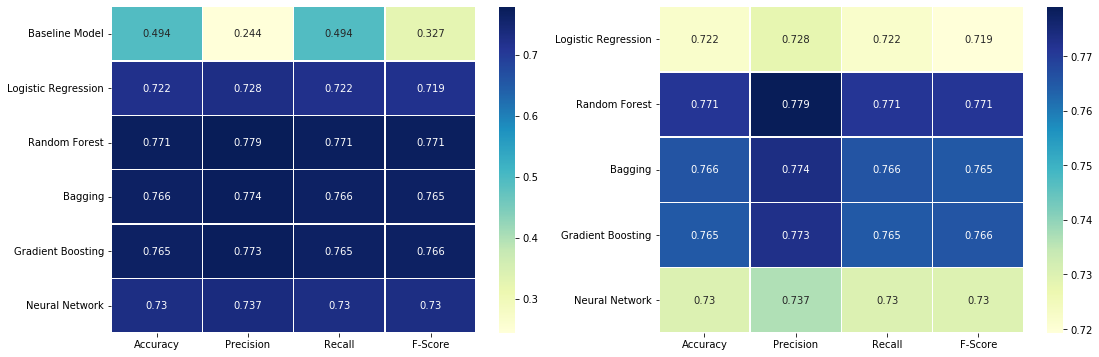

In [ ]:
plt.figure(figsize=(18, 6));
plt.subplot(1,2,1);
sns.heatmap(comparison, cmap="YlGnBu", annot=True, fmt='.3g', linewidths=.5);

plt.subplot(1,2,2);
sns.heatmap(comparison.iloc[1:,:], cmap="YlGnBu", annot=True, fmt='.3g', linewidths=.5);

## 4.2 Model Evaluation

In [ ]:
# Use the bootstrap to carefully test which model performs best. 
# Which model would you recommend for this problem? For your chosen model, 
# again use the bootstrap to construct a confidence interval for its accuracy.
def accuracy(y_pred, y_test, y_train):
    accuracy = np.mean(y_pred == y_test)
    return accuracy

def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=100, random_state=0):
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array = np.zeros([n_sample, n_metrics])
    output_array[:] = np.nan
    
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter] = metrics(bs_predicted, bs_label, train_label)
            
    output_df = pd.DataFrame(output_array)
    return output_df

In [ ]:
models = [rf.fit(X_train, y_train),
          bag.fit(X_train, y_train),
          gb.fit(X_train, y_train)]

output_table = pd.DataFrame()
for model in models:
    tic = time.time()
    bs_output = bootstrap_validation(X_test, y_test, y_train, model,
                                     metrics_list=[accuracy],
                                     sample=300) #
    output_table = pd.concat([output_table, bs_output], axis=1)
    toc = time.time()
    print(round(toc - tic, 2), "seconds")

performance_table = pd.DataFrame(zip(np.mean(output_table), np.std(output_table)), 
                                 index=['Random Forest', 'Bagging', 'Gradient Boosting'],
                                 columns=['Accuracy Mean', 'Accuracy std']).T
performance_table

21.54 seconds
23.0 seconds
4.55 seconds


,Random Forest,Bagging,Gradient Boosting
Accuracy Mean,0.770897,0.765462,0.764934
Accuracy std,0.007154,0.007310,0.007365


95-percent CI of accuracy is [0.75573305 0.78411466]


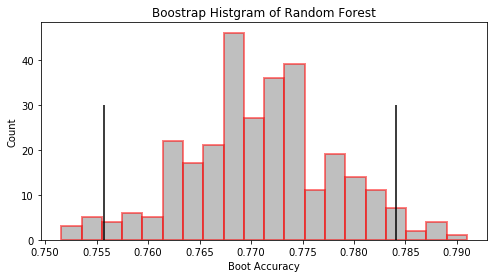

In [ ]:
# Choose Random Forest
CI = np.quantile(output_table.iloc[:,0], np.array([0.025, 0.975]))
print("95-percent CI of accuracy is %s" % CI)

fig, axs = plt.subplots(ncols=1, figsize=(8, 4));
axs.set_xlabel('Boot Accuracy');
axs.set_ylabel('Count');
axs.hist(output_table.iloc[:,0], bins=20, edgecolor='red', linewidth=2, color="grey", alpha=0.5);
axs.vlines(x=CI[0], ymin=0, ymax=30, color="black");
axs.vlines(x=CI[1], ymin=0, ymax=30, color="black");
plt.title("Boostrap Histgram of Random Forest");